In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
from functools import reduce
from pandasql import sqldf
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import heapq

pysqldf = lambda q: sqldf(q, globals())

import os

path = os.getcwd() + r'/archive' # use your path
# print(path)
# all_files = glob.glob(os.path.join(path , "/*.csv"))
# print(all_files)


directory = ""
li = []

for filename in sorted(os.listdir(path)):
    if(filename == "merged_data.csv"):
        continue
    file = os.path.join(path, filename)
    df = pd.read_csv(file)
    li.append(df)
print(len(li))

9


In [2]:
df_customers, df_geolocation, df_order_items, df_order_payments, df_order_reviews, df_orders, df_products, df_sellers, df_category_name_translation = li
print(df_customers)

                            customer_id                customer_unique_id  \
0      06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1      18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2      4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3      b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4      4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   
...                                 ...                               ...   
99436  17ddf5dd5d51696bb3d7c6291687be6f  1a29b476fee25c95fbafc67c5ac95cf8   
99437  e7b71a9017aa05c9a7fd292d714858e8  d52a67c98be1cf6a5c84435bd38d095d   
99438  5e28dfe12db7fb50a4b2f691faecea5e  e9f50caf99f032f0bf3c55141f019d99   
99439  56b18e2166679b8a959d72dd06da27f9  73c2643a0a458b49f58cea58833b192e   
99440  274fa6071e5e17fe303b9748641082c8  84732c5050c01db9b23e19ba39899398   

       customer_zip_code_prefix          customer_city customer_state  
0  

In [3]:
order_customers = [df_orders, df_customers]
merged_orders_customers = reduce(lambda left, right: pd.merge(left, right, on=["customer_id"], how="inner"), order_customers)
order_customers_items = [merged_orders_customers, df_order_items]
merged_orders_customers_items = reduce(lambda left, right: pd.merge(left, right, on=["order_id"], how='inner'), order_customers_items)
order_customers_items_products = [merged_orders_customers_items, df_products]
merged_orders_customers_items_products = reduce(lambda left, right: pd.merge(left, right, on=["product_id"], how='inner'), order_customers_items_products)
order_customers_items_products_names = [merged_orders_customers_items_products, df_category_name_translation]
merged_orders_customers_items_products_names = reduce(lambda left, right: pd.merge(left, right, on=["product_category_name"], how='inner'), order_customers_items_products_names)


In [4]:
df_aggregate_product = pd.DataFrame(merged_orders_customers_items_products_names['product_id'].unique(), columns=["product_id"])

q = pysqldf("""
    SELECT product_id, AVG(review_score) as average_score FROM merged_orders_customers_items_products_names NATURAL JOIN df_order_reviews GROUP BY 1
    HAVING COUNT(product_id) > 50
""")
df_aggregate_product = reduce(lambda left, right: pd.merge(left, right, on=["product_id"], how="inner"), [df_aggregate_product, q])

q = pysqldf("""
    SELECT product_id, COUNT(product_id) as times_bought FROM merged_orders_customers_items GROUP BY product_id
""")
scaler = StandardScaler()
df_aggregate_product = reduce(lambda left, right: pd.merge(left, right, on=["product_id"], how="inner"), [df_aggregate_product, q])
temp = df_aggregate_product[['average_score', 'times_bought']]
temp = pd.DataFrame(scaler.fit_transform(temp), columns=["average_score", "times_bought"])
# print(temp)
df_aggregate_product['std_average_score'] = temp['average_score']
df_aggregate_product['std_times_bought'] = temp['times_bought']
print(df_aggregate_product)

                           product_id  average_score  times_bought  \
0    42a2c92a0979a949ca4ea89ec5c7b934       4.000000           183   
1    e9a69340883a438c3f91739d14d3a56d       4.000000            58   
2    30ac6df06dc59ad72cf2f158fc2d904c       3.944444            55   
3    d696750e550fd0f733979dd7e5dff921       4.526316            57   
4    5a6e53c3b4e8684b13388d6aa4afdf12       4.164384            73   
..                                ...            ...           ...   
163  35afc973633aaeb6b877ff57b2793310       3.820359           165   
164  0aabfb375647d9738ad0f7b4ea3653b1       4.204225           142   
165  6c3effec7c8ddba466d4f03f982c7aa3       3.894737            97   
166  cd48f265a63e13b762601f5f794c5fca       4.236559            93   
167  4fe644d766c7566dbc46fb851363cb3b       3.754717           107   

     std_average_score  std_times_bought  
0            -0.093834          0.900215  
1            -0.093834         -0.609248  
2            -0.252699        

Text(0, 0.5, 'Times Bought')

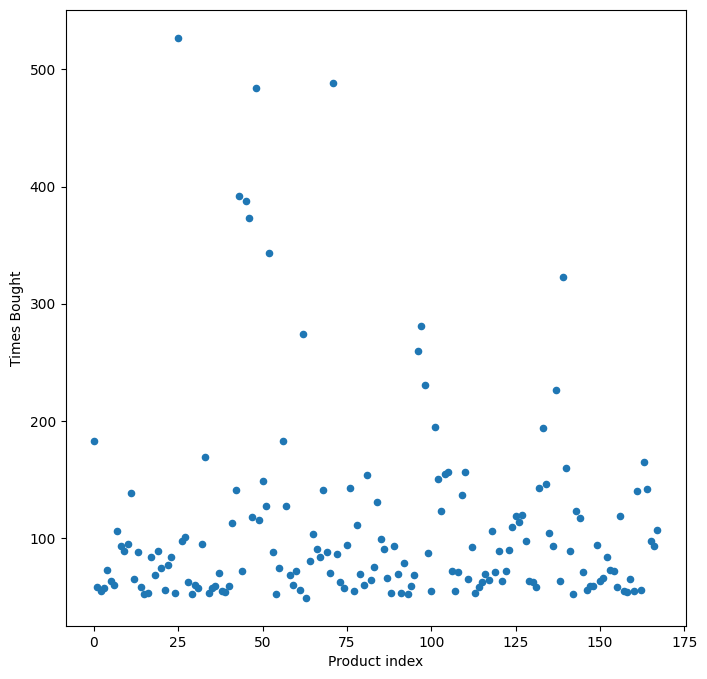

In [5]:
products_bought_graph = df_aggregate_product.iloc[:500].reset_index().plot(x='index', y='times_bought', kind='scatter', figsize=(8,8))
products_bought_graph.set_xlabel("Product index")
products_bought_graph.set_ylabel("Times Bought")


Text(0, 0.5, 'Review Score')

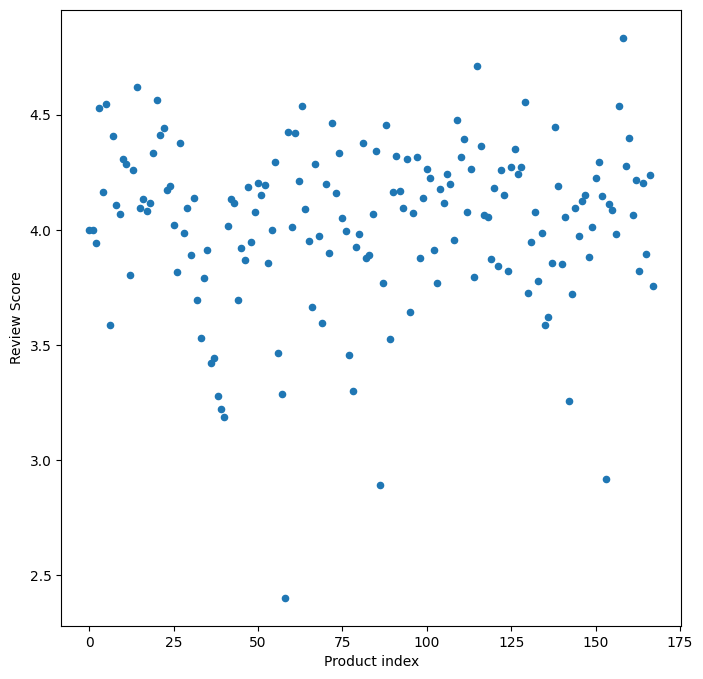

In [6]:

products_review_graph = df_aggregate_product.iloc[:500].reset_index().plot(x='index', y='average_score', kind='scatter', figsize=(8,8))
products_review_graph.set_xlabel("Product index")
products_review_graph.set_ylabel("Review Score")

In [7]:
merged_orders_customers_items_products_names = merged_orders_customers_items_products_names.drop(columns=["order_status", "order_purchase_timestamp", "order_approved_at", "order_delivered_carrier_date", "order_delivered_customer_date", "order_estimated_delivery_date", "customer_zip_code_prefix", "customer_city", "order_item_id", "seller_id", "shipping_limit_date", "price", "freight_value", "product_category_name", "product_name_lenght", "product_description_lenght", "product_photos_qty", "product_weight_g", "product_length_cm", "product_width_cm", "product_height_cm", "customer_id"])
merged_orders_customers_items_products_names.to_csv(os.path.join(path, "merged_data.csv"), index=False)

In [8]:
df_filtered = merged_orders_customers_items_products_names[['customer_unique_id', 'product_category_name_english', 'product_id']]
y = pd.Categorical(df_filtered['product_category_name_english']).codes
y = pd.DataFrame(y, columns=['product_category_name_english'])
df_filtered = df_filtered.drop('product_category_name_english', axis=1);
df_filtered = df_filtered.join(y);
y = pd.Categorical(df_filtered['customer_unique_id']).codes
y = pd.DataFrame(y, columns=['customer_unique_id'])
df_filtered = df_filtered.drop('customer_unique_id', axis=1);
df_filtered = df_filtered.join(y);

df_table = df_filtered.pivot_table(index="product_id", columns="product_category_name_english").fillna(0);
# print(df_table)
df_matrix = csr_matrix(df_table.values)
model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(df_matrix)


q = 10    # This is the row number in the table, but each row is a user so you can get it by user too if you want
pq = []
num_recs = 5    # The number of recs to give
neighbors_to_check = 1000    # The number of neighbors to check
distances, indices = model_knn.kneighbors(df_table.iloc[q,:].values.reshape(1, -1), n_neighbors = neighbors_to_check)
for i in range(0, len(distances.flatten())):
    if i == 0:
#         print('Recommendations for {0}:'.format(df_table.index[0]))
        row = merged_orders_customers_items_products_names.loc[merged_orders_customers_items_products_names['product_id'] == df_table.index[indices.flatten()[0]]]
#         print(row['product_category_name_english'].unique()[0])
        cat = row['product_category_name_english'].unique()[0]
    else:
#         print('{0}: {1}, with distance of {2}:'.format(i, df_table.index[indices.flatten()[i]], distances.flatten()[i]))
        row = merged_orders_customers_items_products_names.loc[merged_orders_customers_items_products_names['product_id'] == df_table.index[indices.flatten()[i]]]
#         print(row['product_category_name_english'].unique()[0])
        if (cat == row['product_category_name_english'].unique()[0]):
            df_rec = df_aggregate_product.loc[df_aggregate_product['product_id'] == df_table.index[indices.flatten()[i]]]
            if(len(df_rec)): 
                score = df_rec.iloc[0]['std_average_score']+df_rec.iloc[0]['std_times_bought']
                if (len(pq) < num_recs):
                    heapq.heappush(pq, (score, (df_rec.iloc[0]['product_id'])))
                else:
                    if (score > pq[0][0]): 
                        heapq.heappop(pq)
                        heapq.heappush(pq, (score, (df_rec.iloc[0]['product_id'])))

for x in pq:
    print(df_aggregate_product.loc[df_aggregate_product['product_id'] == x[1]][['product_id', 'average_score', 'times_bought']])

                          product_id  average_score  times_bought
83  64fb265487de2238627ce43fe8a67efc       3.891892            75
                          product_id  average_score  times_bought
73  25f86162fee18735fffdb762dcb10d7c        4.16129            62
                          product_id  average_score  times_bought
70  2a2d22ae30e026f1893083c8405ca522       4.197183            70
                          product_id  average_score  times_bought
84  ec2d43cc59763ec91694573b31f1c29a       4.069231           131


Text(0, 0.5, 'Times Bought')

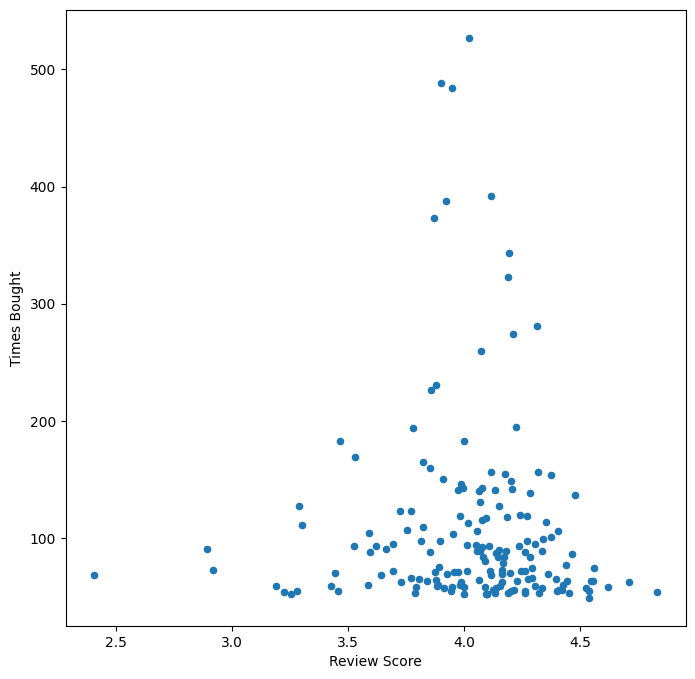

In [9]:
products_review_bought_graph = df_aggregate_product.iloc[:500].reset_index().plot(x='average_score', y='times_bought', kind='scatter', figsize=(8,8))
products_review_bought_graph.set_xlabel("Review Score")
products_review_bought_graph.set_ylabel("Times Bought")

In [10]:
df_aggregate_category = pd.DataFrame(merged_orders_customers_items_products_names['product_category_name_english'].unique(), columns=["product_category_name_english"])
q = pysqldf("""
    SELECT product_category_name_english, COUNT(product_category_name_english) AS occurences FROM merged_orders_customers_items_products_names GROUP BY 1
""")
df_aggregate_category = reduce(lambda left, right: pd.merge(left, right, on=["product_category_name_english"], how="inner"), [df_aggregate_category, q])

Text(0, 0.5, 'Times Bought')

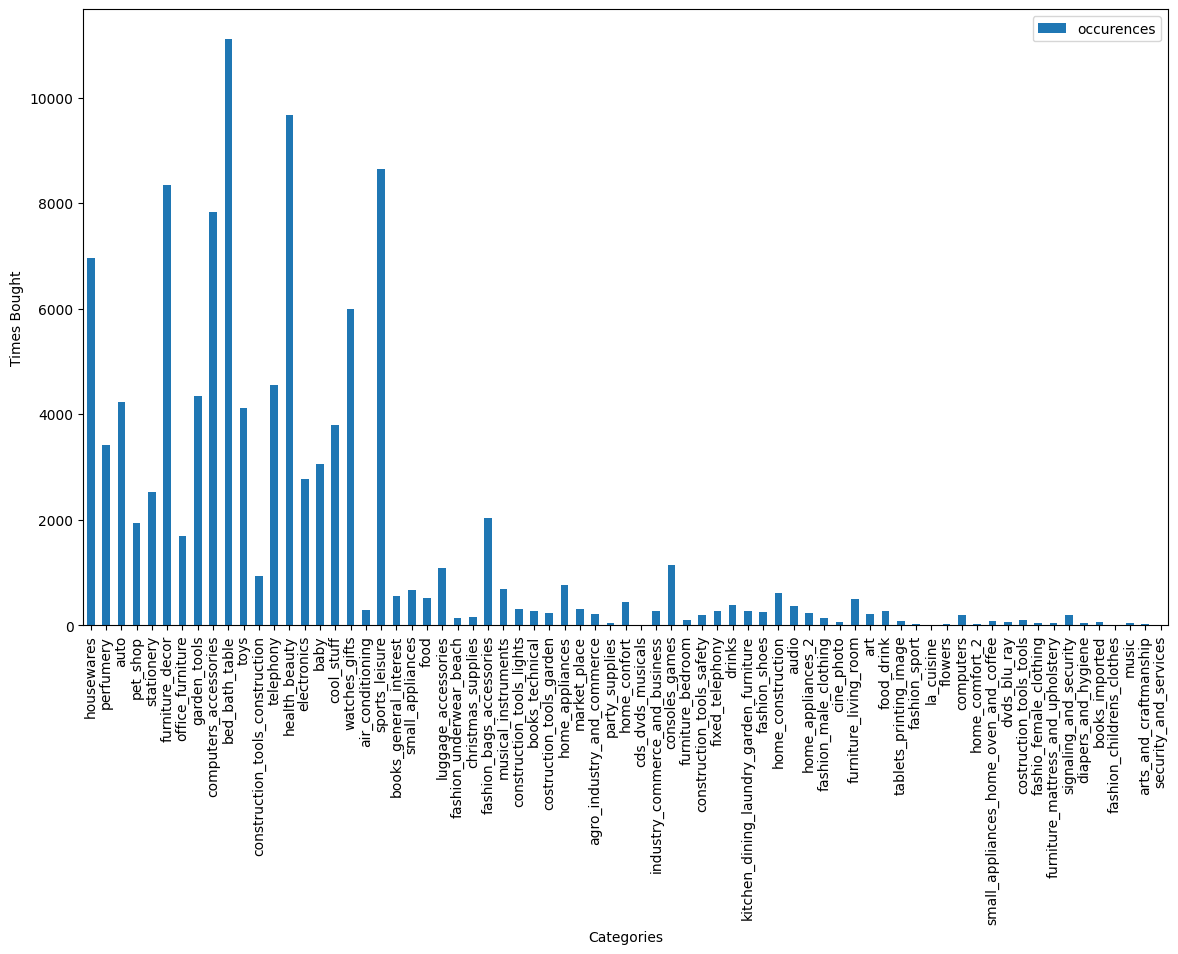

In [11]:
category_bought_graph = df_aggregate_category.iloc[:500].plot(x="product_category_name_english", y="occurences", kind="bar", figsize = (14,8))
category_bought_graph.set_xlabel("Categories")
category_bought_graph.set_ylabel("Times Bought")